# Install important library

In [1]:
pip install rouge-score sacrebleu evaluate torchsummary

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f5c71e8a5fc0efbdb51291f8559c555fe298b7e1c476ae6078062bc71768fdba
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


# Import Library

In [2]:
import torch
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

from datasets import Dataset
from sklearn.model_selection import train_test_split

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torchsummary import summary

from collections import defaultdict
warnings.filterwarnings("ignore")

# Cleaning Data

In [3]:
#Load Data
df = pd.read_csv('/kaggle/input/cancer-q-and-a-dataset/Genetic_and_Rare_DiseasesQA.csv')

# Sampel Data
print("Data Sample")
print(df.head())

#Null value
print("Null Value Data")
print(df.isnull().sum())

# List of question words
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Ensure questions are lowercase for consistent filtering
df['Question'] = df['Question'].str.lower()

# Filter rows where the question starts with a question word
df = df[df['Question'].str.split().str[0].isin(question_words)]

df = df.reset_index(drop=True)

# Check for duplicate rows
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

#Delete Unused column
df = df.drop(columns=['topic', 'split'])

#Table Info
print("Table Info")
print(df.info())

# Apply the function
df = df.drop_duplicates(subset='Question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='Answer', keep='first').reset_index(drop=True)

#Drop rows with null values
df = df.drop_duplicates(subset=['Question', 'Answer']).reset_index(drop=True)
df['Question'] = df['Question'].fillna('').astype(str)
df['Answer'] = df['Answer'].fillna('').astype(str)

# Removing "(are)" in the dataset
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r'\s+', ' ', text.strip().lower())
    return text

df['Question'] = df['Question'].apply(clean_text)
df['Answer'] = df['Answer'].apply(clean_text)

df['Question'] = df['Question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['Answer'] = df['Answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

#Checking again of null values
print("Null Value Data")
print(df.isnull().sum())

#Check for Unique Data
print(f"Unique questions: {df['Question'].nunique()}")
print(f"Unique answers: {df['Answer'].nunique()}")

#Checking again of the data info
df.info()
df.head()

Data Sample
                                            Question  \
0           What is (are) Hypothalamic dysfunction ?   
1  What are the symptoms of Hypothalamic dysfunct...   
2             What causes Hypothalamic dysfunction ?   
3  What are the treatments for Hypothalamic dysfu...   
4  What are the symptoms of Mental retardation X-...   

                                              Answer  \
0  Hypothalamic dysfunction refers to a condition...   
1  What are the signs and symptoms of hypothalami...   
2  What causes hypothalamic dysfunction? Hypothal...   
3  How might hypothalamic dysfunction be treated?...   
4  What are the signs and symptoms of Mental reta...   

                       topic  split  
0  Genetic_and_Rare_Diseases  train  
1  Genetic_and_Rare_Diseases  train  
2  Genetic_and_Rare_Diseases  train  
3  Genetic_and_Rare_Diseases  train  
4  Genetic_and_Rare_Diseases  train  
Null Value Data
Question    0
Answer      0
topic       0
split       0
dtype: int64
N

,Question,Answer
0,what is hypothalamic dysfunction ?,hypothalamic dysfunction refers to a condition...
1,what are the symptoms of hypothalamic dysfunct...,what are the signs and symptoms of hypothalami...
2,what causes hypothalamic dysfunction ?,what causes hypothalamic dysfunction? hypothal...
3,what are the treatments for hypothalamic dysfu...,how might hypothalamic dysfunction be treated?...
4,what are the symptoms of mental retardation x-...,what are the signs and symptoms of mental reta...


# Architecting Model

In [4]:
# Load T5-small model and tokenizer
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)
config.dropout_rate = 0.1
config.feed_forward_proj = "gelu"  
model = T5ForConditionalGeneration.from_pretrained(
    model_name, 
    config=config
)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Tie weights explicitly
model.resize_token_embeddings(len(tokenizer))

# Print model architecture summary
# Print detailed model summary
print("\nDetailed Model Summary:")
print("=" * 50)

def summarize_model_by_type(model):
    layer_summary = defaultdict(int)
    param_summary = defaultdict(int)

    for name, module in model.named_modules():
        layer_type = type(module).__name__
        layer_summary[layer_type] += 1
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())

    print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}")
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)

# Preprocess function for seq2seq task
def preprocess_function(batch):
    inputs = [f"answer the following question: {q}" for q in batch['Question']]
    targets = [f"{a}" for a in batch['Answer']]
    
    model_inputs = tokenizer(
        inputs,
        max_length=128,  
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=64,  
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
    
    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
# print('Halo: ',val_dataset.column_names)

# Preprocess datasets
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  
    remove_columns=train_dataset.column_names,
    num_proc=4,   
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  
    remove_columns=val_dataset.column_names,
    num_proc=4,  
)


# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    # eval_steps=1000,  
    # save_steps=1000,  
    save_total_limit=2,  
    learning_rate=5e-4,   
    num_train_epochs=5,   
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8, 
    lr_scheduler_type="cosine_with_restarts",  
    warmup_ratio=0.1,  
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=True,   
    logging_dir="./logs",
    logging_steps=50,  
    # load_best_model_at_end=True,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=2,   
    max_grad_norm=0.5,
    optim="adamw_torch_fused",  
    generation_max_length=64,  
    generation_num_beams=6,
    dataloader_num_workers=4,   
    group_by_length=True, 
    remove_unused_columns=True,
    label_smoothing_factor= 0.1
)

# training_args.label_smoothing_factor = 0.1
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model,  
    padding='longest',  
)

# Create function to show exact match, BLEU and ROUGE
def compute_metrics(eval_pred, tokenizer):
    predictions, labels = eval_pred
    
    # Decode predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Normalize text
    decoded_preds = [text.strip().lower() for text in decoded_preds]
    decoded_labels = [text.strip().lower() for text in decoded_labels]
    
    # Multiple metrics
    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])
    
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    
    bleu_score = bleu_metric.compute(
        predictions=decoded_preds, 
        references=[[label] for label in decoded_labels]
    )["bleu"]
    
    rouge_score = rouge_metric.compute(
        predictions=decoded_preds, 
        references=decoded_labels
    )["rougeL"]
    
    return {
        "exact_match": exact_match,
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
    }

# Initialize data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',
    return_tensors="pt"
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer)
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

# Save log history
log_history = trainer.state.log_history

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Detailed Model Summary:
Layer Type                    Count     Parameters     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


Map (num_proc=4):   0%|          | 0/4537 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/801 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,2.783900,2.574686,0.343321,0.490820,0.583290
2,2.556800,2.514614,0.352060,0.498931,0.585975
3,2.465000,2.467274,0.358302,0.499458,0.587866
4,2.348200,2.475084,0.359551,0.503570,0.588935
5,2.317500,2.467451,0.359551,0.505584,0.591266


# Show graphics

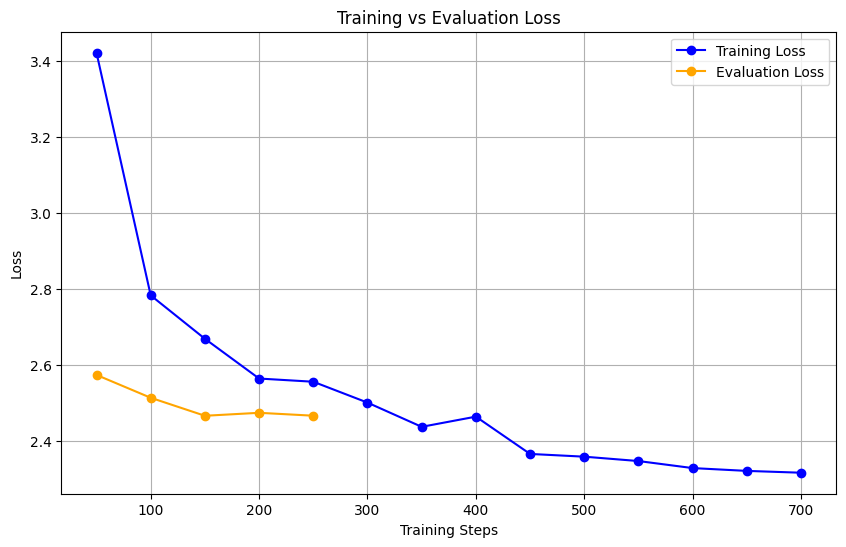

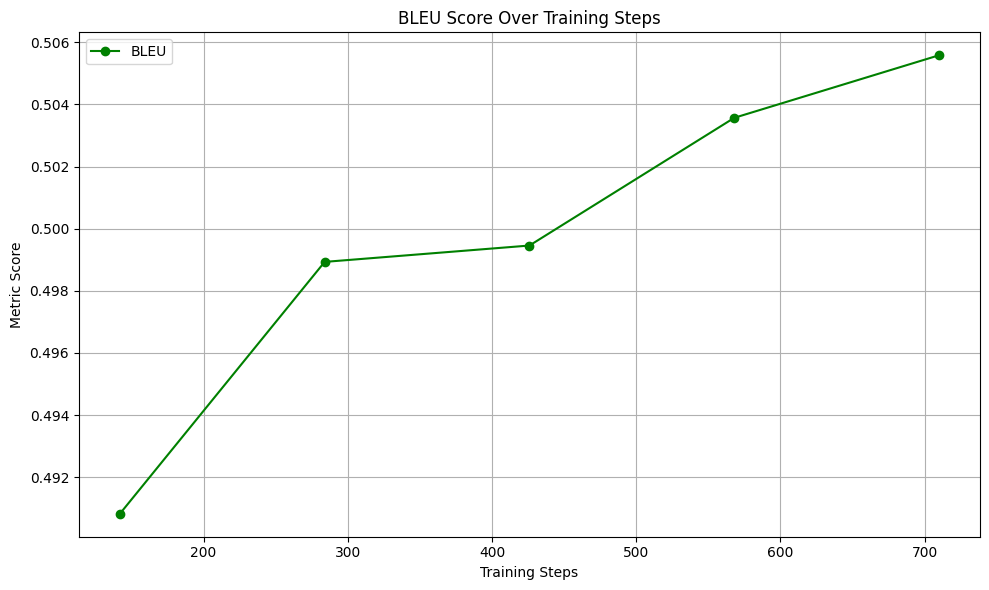

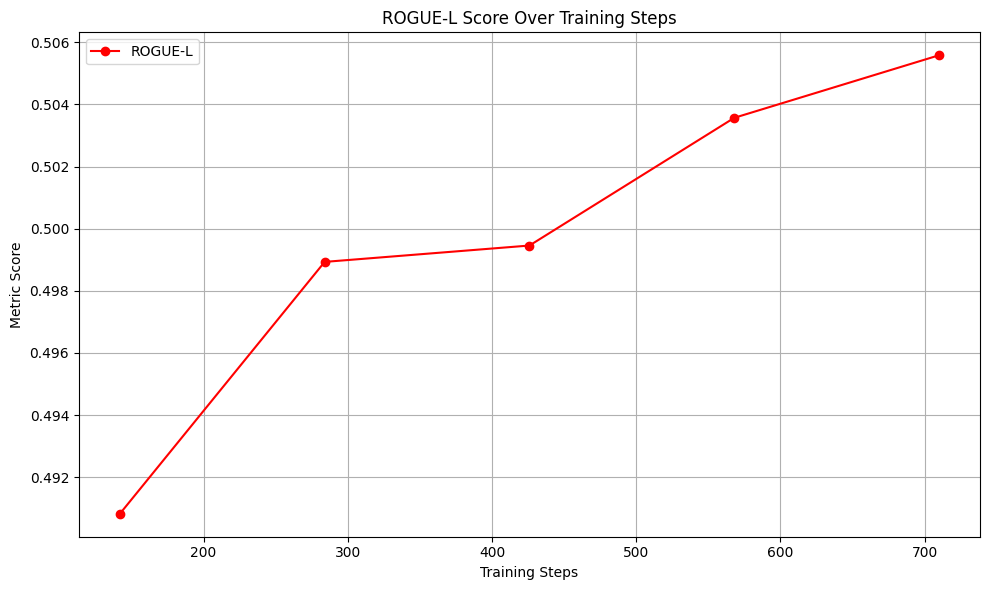

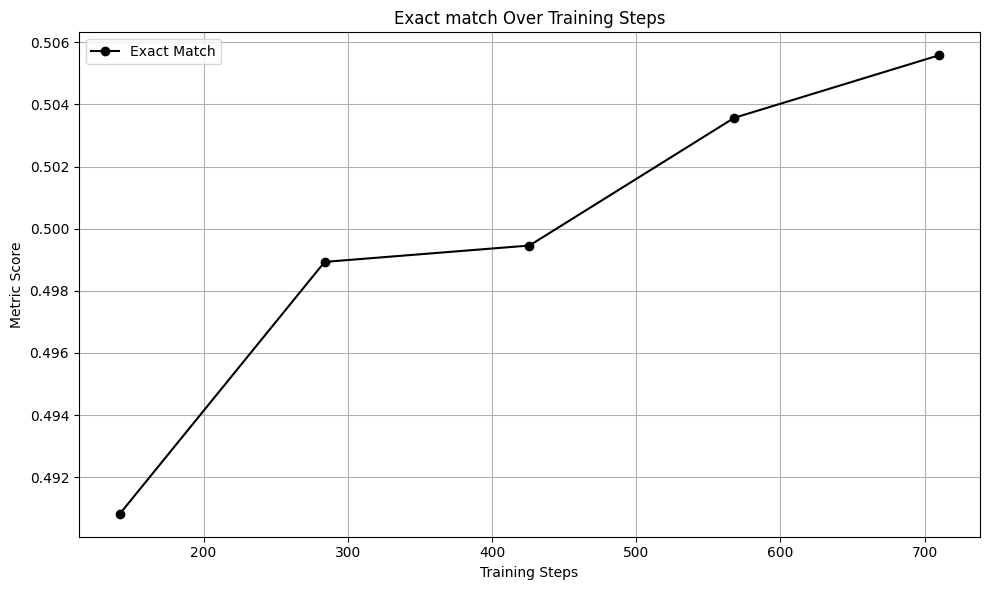

In [5]:
# Extract loss values from log history
train_loss = []
eval_loss = []
eval_bleu = []
eval_exact_match = []
eval_rogue = []
steps = []
eval_steps = []

for log in log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_BLEU" in log:
        eval_bleu.append(log["eval_BLEU"])
    if "eval_ROUGE-L" in log:
        eval_rogue.append(log["eval_ROUGE-L"])
    if "eval_exact_match" in log:
        eval_exact_match.append(log["eval_exact_match"])

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue", marker="o")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", color="orange", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot the BLEU
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="BLEU", marker="o", linestyle="-", color="green")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("BLEU Score Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the ROGUE
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="ROGUE-L", marker="o", linestyle="-", color="red")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("ROGUE-L Score Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the BLEU
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="Exact Match", marker="o", linestyle="-", color="black")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("Exact match Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing using Input

In [6]:
# Load the trained T5 model and tokenizer
model_path = "/kaggle/working/t5_chatbot_model"
tokenizer_path = "/kaggle/working/t5_chatbot_tokenizer"

tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval() 

# Generate responses using Top-K and Top-P sampling
# Generate responses using Top-K and Top-P sampling with EOS token handling
def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=200, top_k=50, top_p=0.95, temperature=0.7
):
    # Format the question for the model
    formatted_question = f"Answer the following question: {question}"
    
    # Tokenize the input
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    )
    
    # Generate response with top-k and top-p sampling
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        repetition_penalty=2.0,
        max_length=max_length,
        do_sample=True,  # Enables sampling instead of greedy/beam search
        top_k=top_k,  # Top-K sampling
        top_p=top_p,  # Nucleus sampling
        temperature=temperature,  # Adjusts randomness
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,  # Ensure stopping at EOS token
    )
    
    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Check if the response ends with a complete sentence, add period if missing
    if not response.endswith(('.', '!', '?')):
        response += '.'

    return response

# Example usage
question = "What is sarcoidosis?"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)


Question: What is sarcoidosis?
Response: sarcoidosis is a rare type of sarcoidosis, which is a chronic condition that affects the kidneys. it is characterized by an abnormal formation of the organs and tissues of the body. signs and symptoms may include a severe, fever-like headache, muscle weakness,.


Gradio Interface

In [7]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the trained T5 model and tokenizer
model_path = "/kaggle/working/t5_chatbot_model"
tokenizer_path = "/kaggle/working/t5_chatbot_tokenizer"

tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [8]:
# Generate responses using Top-K and Top-P sampling
def generate_response_top_k_top_p(
    question, max_length=64, top_k=50, top_p=0.95, temperature=0.7
):
    # Format the question for the model
    formatted_question = f"Answer the following question: {question}"
    
    # Tokenize the input
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    )
    
    # Generate response with top-k and top-p sampling
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        repetition_penalty=1.5,
        max_length=max_length,
        do_sample=True,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        pad_token_id=tokenizer.pad_token_id,
    )
    
    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [9]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.5/450.5 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 36.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found 

In [10]:
import gradio as gr

# Wrapper function for Gradio
def chatbot_interface(question):
    return generate_response_top_k_top_p(question)  # Tetap sesuai logika kamu

# Path ke logo
logo_path = "/kaggle/input/logo-ui/104248.jpg"  # Sesuaikan nama file logo

# Gradio Interface dengan Logo
with gr.Blocks() as demo:
    with gr.Row():
        # Logo dengan ukuran 100x100 px
        gr.Image(value=logo_path, show_label=False, interactive=False, elem_id="logo")
    gr.Markdown("<h1 style='text-align: center;'>GeneBuddy Chatbot</h1>")
    gr.Markdown("Ask questions about genetic and rare diseases. Start exploring now!")
    
    # Input dan Output
    with gr.Row():
        input_box = gr.Textbox(
            label="Input Text", placeholder="Ask me a question...", lines=5
        )
        output_box = gr.Textbox(label="Output Text", lines=10)
    
    # Tombol Submit dan Clear
    with gr.Row():
        submit_btn = gr.Button("Submit")
        clear_btn = gr.Button("Clear")
    
    # Logika Tombol
    submit_btn.click(chatbot_interface, inputs=input_box, outputs=output_box)
    clear_btn.click(lambda: ("", ""), inputs=None, outputs=[input_box, output_box])

# Tambahkan CSS untuk mengatur ukuran logo
demo.css = """
#logo img {
    width: 100px;   /* Lebar logo */
    height: 100px;  /* Tinggi logo */
    margin: 0 auto; /* Pusatkan logo */
    display: block;
}
"""

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://1b64d165d58fab2473.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
